In [2]:
import numpy as np
from skbold.preproc import ConfoundRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

%matplotlib inline

(0.44183383663661979, 4.885571421405234e-49)


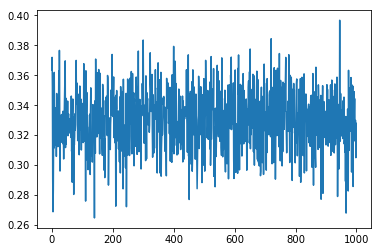

In [4]:
N = 1000
y = np.repeat([0, 1], repeats=N/2)
c = y + np.random.normal(0, 1, N)
X = np.random.normal(0, 1, (N, 1000)) + c[:, np.newaxis]

print(pearsonr(y, c))
plt.plot(np.corrcoef(np.hstack((X, y[:, np.newaxis])).T)[:-1, -1])


In [5]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
mod = LogisticRegression()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

pipe_cfr = Pipeline([
    ('cr', ConfoundRegressor(X=X, confound=c, cross_validate=True)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

pipe_crf_no_cv = Pipeline([
    ('cr', ConfoundRegressor(X=X, confound=c, cross_validate=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

## Do nothing with confound

In [ ]:
scores = cross_val_score(estimator=LogisticRegression(), X=X, y=y)
scores.mean()

## WDCR

In [ ]:
Xwd = ConfoundRegressor(X=X, confound=c, cross_validate=True).fit_transform(X)
scores = cross_val_score(estimator=LogisticRegression(), X=Xwd, y=y, cv=cv, n_jobs=3)
scores.mean()

## FwCR

In [ ]:
scores = np.zeros(100)
scores = cross_val_score(estimator=pipe_cfr, X=X, y=y, cv=cv, n_jobs=3)
scores.mean()

## FwCR (no CV)

In [ ]:
scores = np.zeros(100)
scores = cross_val_score(estimator=pipe_crf_no_cv, X=X, y=y, cv=cv, n_jobs=3)
scores.mean()

## FwCR (only train)

In [21]:
scores = np.zeros(100)
crf = ConfoundRegressor(X=X, confound=c, cross_validate=True)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(cv.split(X, y))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train2 = crf.fit_transform(X_train)
    mod.fit(X_train2, y_train)
    scores[i] = mod.score(X_test, y_test)
scores.mean()

0.49579999999999996

Kind of weird. Even if you regress out from train only, there is above chance classification. Maybe because c is not perfectly correlated with y?

## FwCR (only test)

In [18]:
scores = np.zeros(100)
crf = ConfoundRegressor(X=X, confound=c, cross_validate=True)
for i, (train_idx, test_idx) in tqdm_notebook(enumerate(cv.split(X, y))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_test = crf.fit_transform(X_test)
    mod.fit(X_train, y_train)
    scores[i] = mod.score(X_test, y_test)
scores.mean()

0.5171